# 고객세분화(비슷한 사람끼리 묶어봐라)

# 데이터
## import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (5,5)
matplotlib.rcParams.update({'font.size': 13})

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA 

## 데이터 읽기

In [3]:
## 데이터 다운로드

data = pd.read_csv('https://raw.githubusercontent.com/ShubhankarRawat/Mall-Customers-Segmentation/master/data.csv')
print(data.shape)
print(data.Gender.value_counts())
data.head()

(200, 5)
Female    112
Male       88
Name: Gender, dtype: int64


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 전처리
- 성별을 One Hot Encoding 

In [4]:
## 데이터 전처리

# 컬럼 삭제
df = data.copy()
df = df.drop("CustomerID", axis=1)

# 카테고리 인코딩 (성별)
df.Gender = df.Gender.map({"Male":0, "Female":1})

# 스케일링
scaler = StandardScaler()
continuous = df.columns.difference(['Gender'])
df[continuous] = scaler.fit_transform(df[continuous])
df[:5]

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,-1.424569,-1.738999,-0.434801
1,0,-1.281035,-1.738999,1.195704
2,1,-1.352802,-1.700830,-1.715913
3,1,-1.137502,-1.700830,1.040418
4,1,-0.563369,-1.662660,-0.395980


In [6]:
## 클러스터링 수행

kmeans = KMeans(5).fit(df) # 5개의 그룹으로 만들어봐. 근데 5인지 어떻게 아나? 최적의 클러스터 수찾는 방법?

# 개인별 클러스터 번호 보기
df["Cluster"] = kmeans.labels_
print(df["Cluster"].value_counts())
df[:5]

0    58
4    47
3    39
2    34
1    22
Name: Cluster, dtype: int64


,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,0,-1.424569,-1.738999,-0.434801,4
1,0,-1.281035,-1.738999,1.195704,1
2,1,-1.352802,-1.700830,-1.715913,4
3,1,-1.137502,-1.700830,1.040418,1
4,1,-0.563369,-1.662660,-0.395980,4


# 최적의 클러스터 수 찾기

- 덴드로그램
- 실루엣 지수 보기
- mass(inertia)의 변화 보기

## 덴드로그램

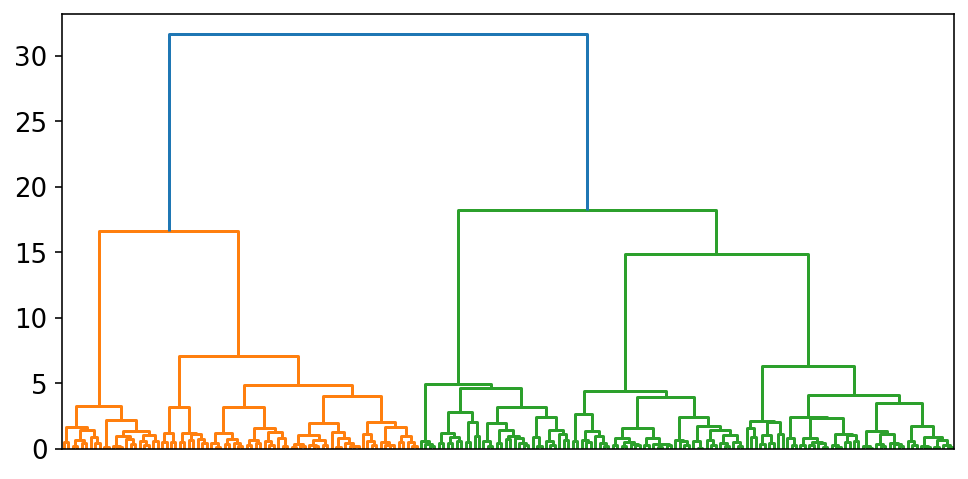

In [7]:
## 덴드로그램

plt.figure(figsize=(8, 4))
link_dist = linkage(df, metric='euclidean', method='ward')  
dendrogram(link_dist, labels=df.index.tolist())
plt.xticks([])
plt.show() # 선이 가장 긴 부분들

## 실루엣 지수

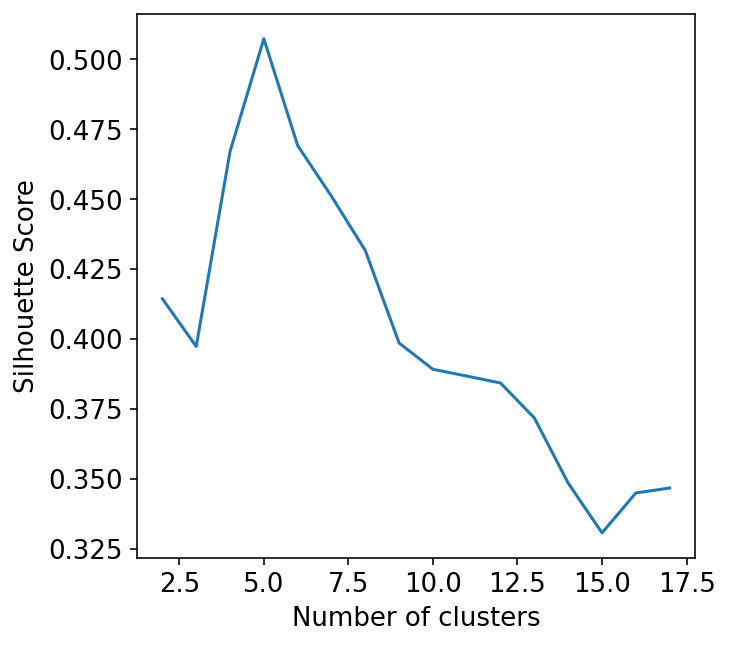

In [10]:
## 실루엣 지수 

results = []
N = 18
for k in range(2,N):
  cluster_labels = KMeans(k).fit_predict(df)
  score = silhouette_score(df, cluster_labels)
  results.append(score)

plt.plot(range(2,N), results)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show() # peak 부분

## knee 포인트

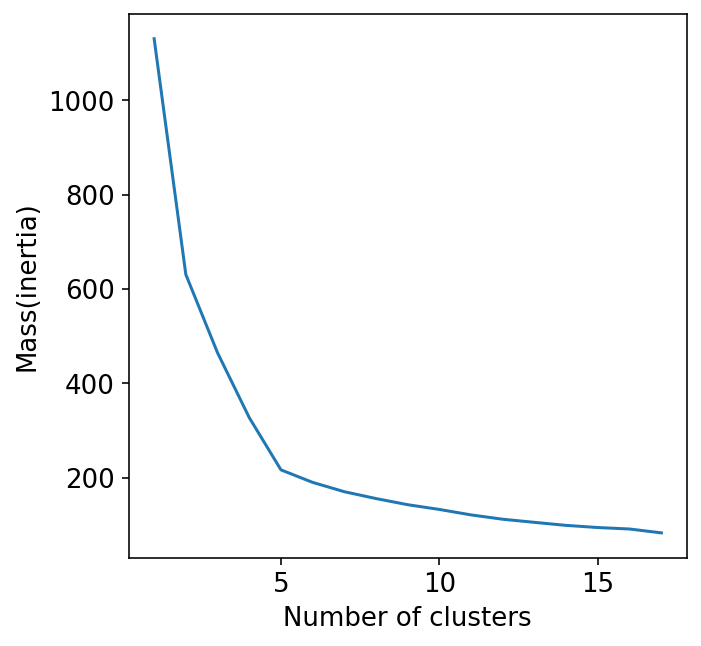

In [11]:
## elbow 포인트 (knee 포인트라고도 한다)

mass = []
for i in range(1, N):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df)
    mass.append(kmeans.inertia_) # 클러스터가 얼마나 무겁냐(inertia:질량)
plt.plot(range(1, N), mass)
plt.xlabel('Number of clusters')
plt.ylabel('Mass(inertia)')
plt.show() # 급변하는데

# 클러스터링 수행
- 클러스터 수 k=4 선택

In [12]:
## 최적의 클러스터링 수행 (k=4)

kmeans = KMeans(4).fit(df)
list(kmeans.labels_[:10])

[3, 2, 3, 2, 3, 2, 3, 2, 1, 2]

## 임의의 특성 공간에서 산포도 그리기

- Age, Annual Income (k$), Spending Score (1-100) 특성 공간에서 그리기

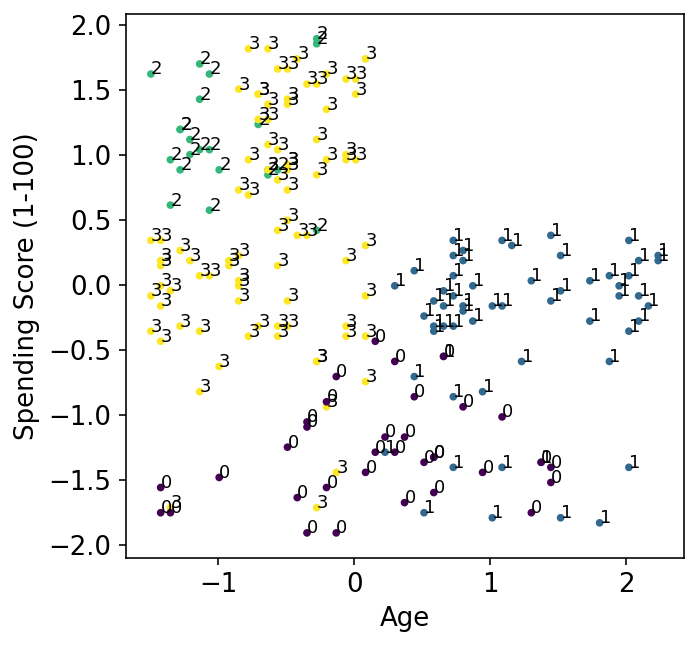

In [13]:
## Age - Spending Score (1-100) 특성 공간 산포도

# 산포도 그리기
plt.scatter(df['Age'], df['Spending Score (1-100)'], 
            c=kmeans.labels_, s=8) 
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')

# 클러스터 번호 쓰기
for n in range(df.shape[0]):
    plt.text(df['Age'][n], df['Spending Score (1-100)'][n],
             kmeans.labels_[n],
            fontsize=9)

- Spending Score (1-100), Annual Income (k$) 특성 공간에서 그리기

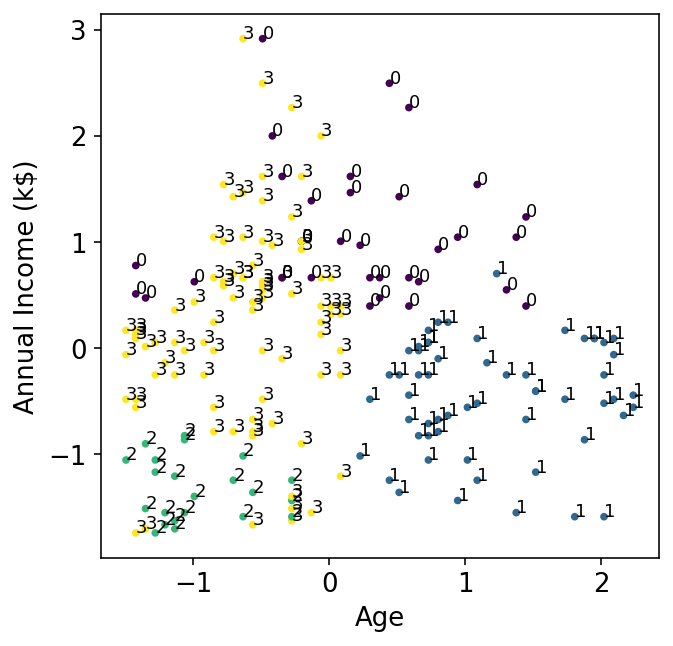

In [14]:
## Age - Annual Income (k$) 특성 공간 산포도

# 산포도 그리기
plt.scatter(df['Age'], df['Annual Income (k$)'], 
            c=kmeans.labels_, s=8) 
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')

# 클러스터 번호 쓰기
for n in range(df.shape[0]):
    plt.text(df['Age'][n], df['Annual Income (k$)'][n],
             kmeans.labels_[n],fontsize=9)


- PCA 개념

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-10-04%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%209.24.09.png?raw=1" align='left'  width=300>

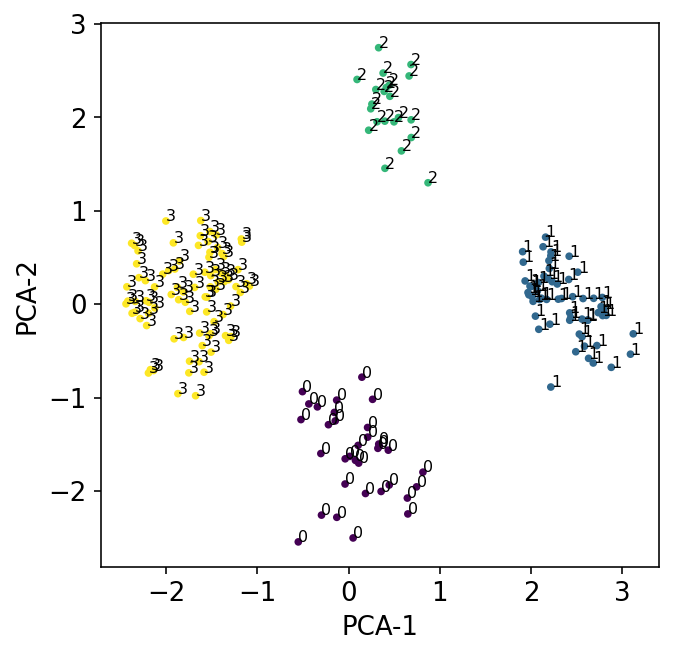

In [15]:
## PCA(2) 공간상에서 산포도 그리기

pca = PCA(2)
X_pca2 = pca.fit_transform(df)

# 산포도 그리기
plt.scatter(X_pca2[:,0],X_pca2[:,1], c=kmeans.labels_, s=8)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')

# 클러스터 번호 쓰기
for n in range(df.shape[0]):
    plt.text(X_pca2[:,0][n], X_pca2[:,1][n], kmeans.labels_[n],
            fontsize=8)

## (참고) 클러스터 수가 3, 4, 5, 6 일때 Spending Score, Annual Income 공간에서 산포도 그리기

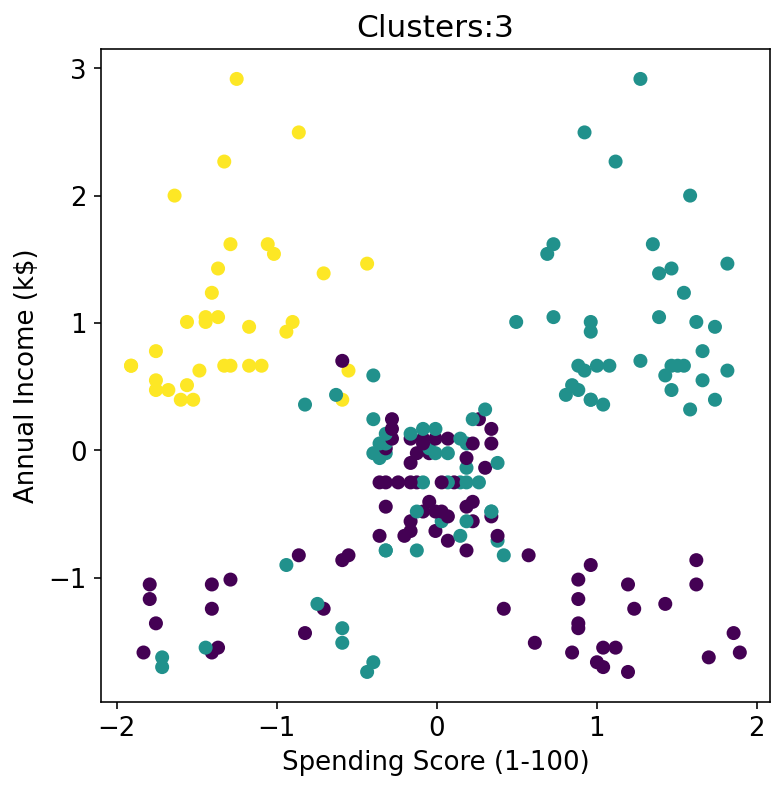

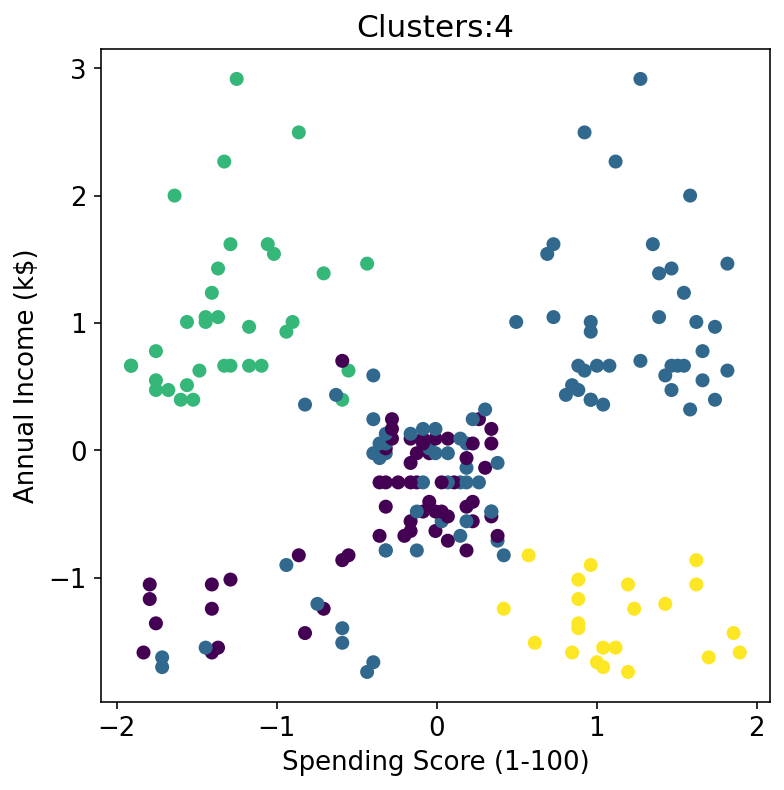

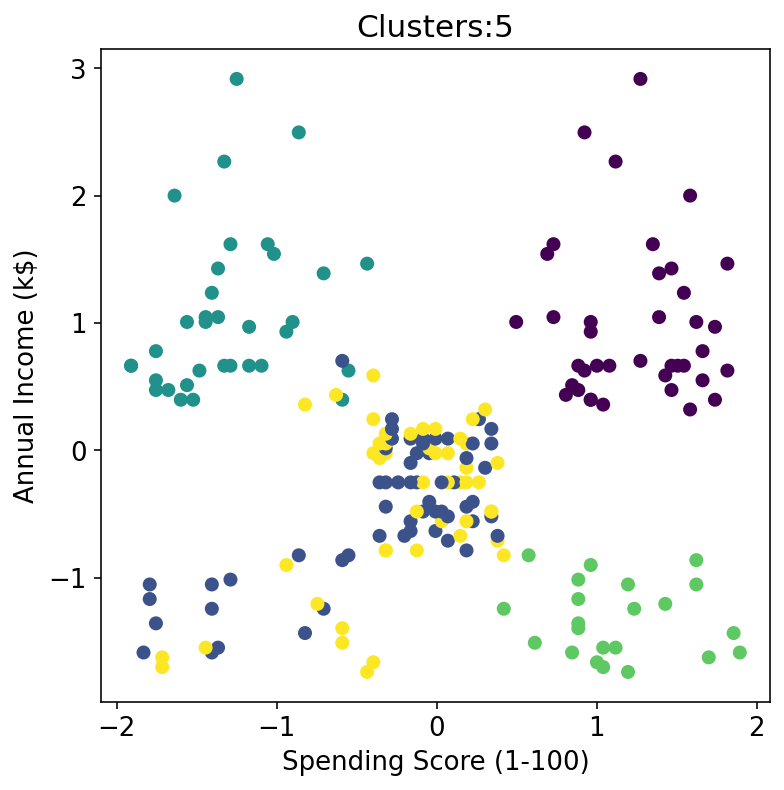

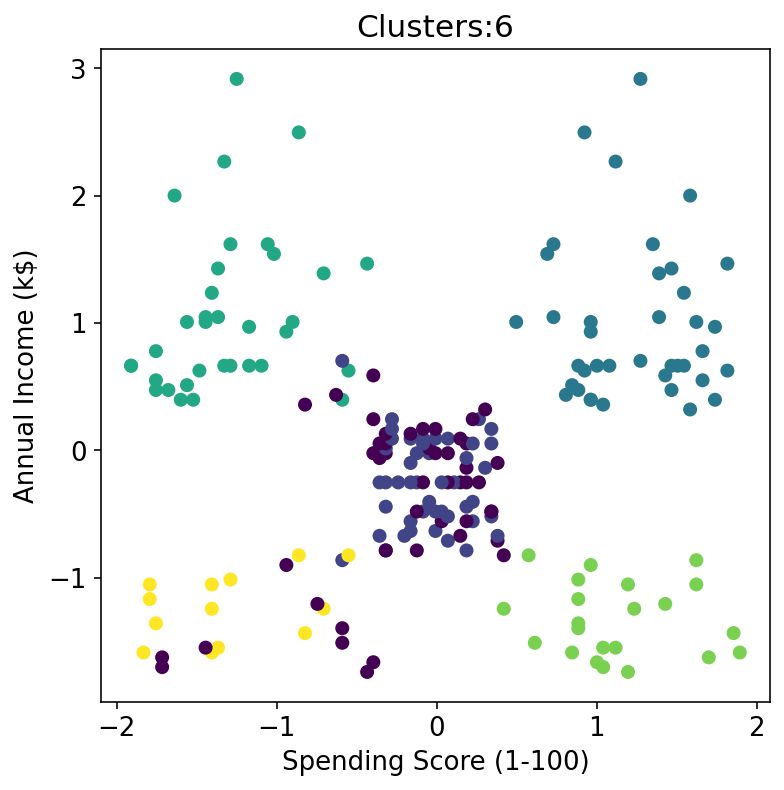

In [16]:
for i in range(3,7):
    kmeans = KMeans(n_clusters = i)
    y_kmeans = kmeans.fit_predict(df)
    plt.figure(figsize=(6,6))
    plt.xlabel('Spending Score (1-100)')
    plt.ylabel('Annual Income (k$)')
    plt.scatter(df['Spending Score (1-100)'], 
                df['Annual Income (k$)'], c=y_kmeans) 
    plt.title('Clusters:'+str(i))
    plt.show()